In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from keras.utils.np_utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet201
from keras import applications
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


Using TensorFlow backend.


In [2]:
#Function for import image
#Return a list of array (each array represent an image in gray lvl)
def importfile(letter, liste, directory) :
    for filename in os.listdir(directory):
        if filename.startswith(letter):
            image = cv2.imread(directory+filename)
            image = cv2.resize(image, (224, 224))
            image = np.array(image)        
            liste.append(image)
    return liste

In [3]:
benign_list = []
importfile('b', benign_list, 'Train/benign/')
benign_labels = []
for i in range (100) :
    benign_labels.append(0)
cancer_list = []
importfile('c', cancer_list, 'Train/cancer/')
cancer_labels = []
for i in range (100) :
    cancer_labels.append(1)

data = benign_list + cancer_list
labels = benign_labels + cancer_labels

In [4]:
benign_list_test = []
importfile('b', benign_list_test, 'Validation/')
benign_labels_test = []
for i in range (101, 151) :
    benign_labels_test.append(0)
cancer_list_test = []
importfile('c', cancer_list_test, 'Validation/')
cancer_labels_test = []
for i in range (101, 151) :
    cancer_labels_test.append(1)

data_test = benign_list_test + cancer_list_test
labels_test = benign_labels_test + cancer_labels_test



In [5]:
benign_train = benign_list
benign_test = benign_list_test
malign_train = cancer_list
malign_test = cancer_list_test

In [6]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [7]:
BATCH_SIZE = 2

train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [8]:
def build_model(backbone, lr=1e-3):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    return model

DenseNet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(DenseNet ,lr = 1e-4)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1920)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3842      
Total params: 18,333,506
Trainable params: 18,100,610
Non-trainable params: 232,896
_________________________________________________________________


In [9]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=10,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="weights.best.1e-4_accuracy.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit_generator(
    train_generator.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(X_test, Y_test),
    callbacks=[learn_control, checkpoint]  
)

Epoch 1/50
100/100 [==============================] - 139s 1s/step - loss: 0.7976 - accuracy: 0.5750 - val_loss: 0.7588 - val_accuracy: 0.6500

Epoch 00001: val_accuracy improved from -inf to 0.65000, saving model to weights.best.1e-4_accuracy.hdf5
Epoch 2/50
100/100 [==============================] - 80s 799ms/step - loss: 0.7393 - accuracy: 0.5850 - val_loss: 0.6635 - val_accuracy: 0.7400

Epoch 00002: val_accuracy improved from 0.65000 to 0.74000, saving model to weights.best.1e-4_accuracy.hdf5
Epoch 3/50
100/100 [==============================] - 80s 803ms/step - loss: 0.7544 - accuracy: 0.5700 - val_loss: 0.5776 - val_accuracy: 0.6900

Epoch 00003: val_accuracy did not improve from 0.74000
Epoch 4/50
100/100 [==============================] - 80s 802ms/step - loss: 0.6899 - accuracy: 0.6550 - val_loss: 0.7810 - val_accuracy: 0.6100

Epoch 00004: val_accuracy did not improve from 0.74000
Epoch 5/50
100/100 [==============================] - 80s 803ms/step - loss: 0.7089 - accuracy:

100/100 [==============================] - 105s 1s/step - loss: 0.5534 - accuracy: 0.7450 - val_loss: 1.5453 - val_accuracy: 0.7000

Epoch 00040: val_accuracy did not improve from 0.82000
Epoch 41/50
100/100 [==============================] - 104s 1s/step - loss: 0.5593 - accuracy: 0.7400 - val_loss: 1.4109 - val_accuracy: 0.7100

Epoch 00041: val_accuracy did not improve from 0.82000
Epoch 42/50
100/100 [==============================] - 106s 1s/step - loss: 0.5392 - accuracy: 0.7500 - val_loss: 1.1615 - val_accuracy: 0.7100

Epoch 00042: val_accuracy did not improve from 0.82000
Epoch 43/50
100/100 [==============================] - 105s 1s/step - loss: 0.5544 - accuracy: 0.7200 - val_loss: 1.4503 - val_accuracy: 0.6900

Epoch 00043: val_accuracy did not improve from 0.82000
Epoch 44/50
100/100 [==============================] - 104s 1s/step - loss: 0.6128 - accuracy: 0.6400 - val_loss: 1.4855 - val_accuracy: 0.7000

Epoch 00044: val_accuracy did not improve from 0.82000
Epoch 45/50


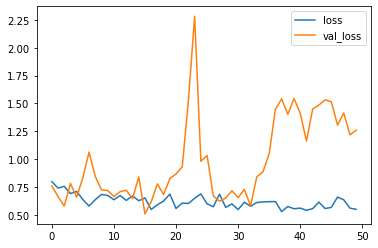

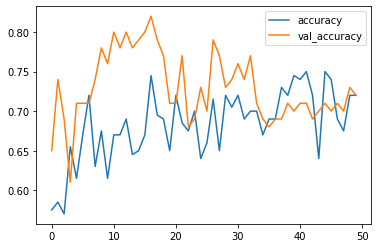

In [10]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [9]:
model = load_model("weights.best.1e-4_accuracy.hdf5")

In [10]:
Y_pred = model.predict(X_test, batch_size=2)

Confusion matrix, without normalization
[[43  7]
 [11 39]]


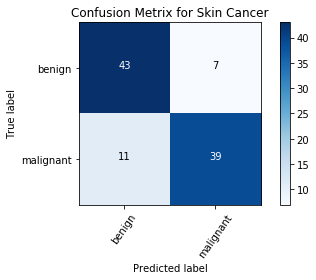

In [11]:
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

# ResNET50

In [12]:
ResNet = applications.resnet50.ResNet50(weights= 'imagenet', include_top=False, input_shape= (224, 224, 3))

model_r = build_model(ResNet ,lr = 1e-4)
model_r.summary()

C:\Users\Anthime\anaconda3\envs\Data_Science\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4098      
Total params: 23,600,002
Trainable params: 23,542,786
Non-trainable params: 57,216
_________________________________________________________________


In [13]:
BATCH_SIZE = 2

train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [14]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=10,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="weights.best.ResNET.1e-4_accuracy_patience10.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history_r = model_r.fit_generator(
    train_generator.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(X_test, Y_test),
    callbacks=[learn_control, checkpoint]  
)

Epoch 1/50
100/100 [==============================] - 67s 674ms/step - loss: 0.9379 - accuracy: 0.5200 - val_loss: 1.2362 - val_accuracy: 0.5500

Epoch 00001: val_accuracy improved from -inf to 0.55000, saving model to weights.best.ResNET.1e-4_accuracy_patience10.hdf5
Epoch 2/50
100/100 [==============================] - 49s 492ms/step - loss: 0.8428 - accuracy: 0.5400 - val_loss: 0.7092 - val_accuracy: 0.7200

Epoch 00002: val_accuracy improved from 0.55000 to 0.72000, saving model to weights.best.ResNET.1e-4_accuracy_patience10.hdf5
Epoch 3/50
100/100 [==============================] - 49s 492ms/step - loss: 0.9631 - accuracy: 0.5650 - val_loss: 0.9450 - val_accuracy: 0.7000

Epoch 00003: val_accuracy did not improve from 0.72000
Epoch 4/50
100/100 [==============================] - 49s 493ms/step - loss: 0.7827 - accuracy: 0.6100 - val_loss: 1.0541 - val_accuracy: 0.6200

Epoch 00004: val_accuracy did not improve from 0.72000
Epoch 5/50
100/100 [==============================] - 49s

100/100 [==============================] - 48s 484ms/step - loss: 0.6153 - accuracy: 0.6700 - val_loss: 0.9236 - val_accuracy: 0.7500

Epoch 00038: val_accuracy did not improve from 0.79000
Epoch 39/50
100/100 [==============================] - 48s 485ms/step - loss: 0.5711 - accuracy: 0.6800 - val_loss: 0.9907 - val_accuracy: 0.7800

Epoch 00039: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.

Epoch 00039: val_accuracy did not improve from 0.79000
Epoch 40/50
100/100 [==============================] - 48s 485ms/step - loss: 0.6176 - accuracy: 0.6700 - val_loss: 1.0113 - val_accuracy: 0.7700

Epoch 00040: val_accuracy did not improve from 0.79000
Epoch 41/50
100/100 [==============================] - 48s 485ms/step - loss: 0.6212 - accuracy: 0.6900 - val_loss: 0.9212 - val_accuracy: 0.7700

Epoch 00041: val_accuracy did not improve from 0.79000
Epoch 42/50
100/100 [==============================] - 48s 485ms/step - loss: 0.6040 - accuracy: 0.7100 - val_loss: 0.9163 

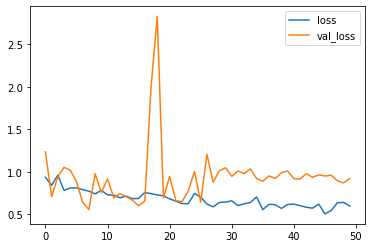

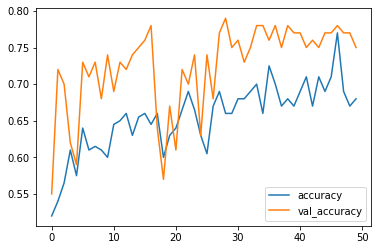

In [17]:
history_df = pd.DataFrame(history_r.history)
history_df[['loss', 'val_loss']].plot()

history_df = pd.DataFrame(history_r.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [18]:
Y_pred = model_r.predict(X_test, batch_size=2)

Confusion matrix, without normalization
[[33 17]
 [ 8 42]]


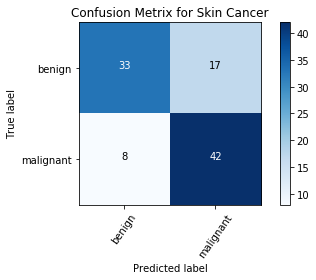

In [19]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

In [16]:
from keras.models import load_model

model = load_model('weights.best.hdf5')

In [23]:
score = model.evaluate(X_test, Y_test, batch_size=2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.48373308998241554
Test accuracy: 0.8399999737739563
